<a href="https://colab.research.google.com/github/YanfeiWang3973/F22-comp2101-Yanfei-Wang/blob/main/Copy_of_StreetCaseAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Street Case assignment**

get Yonge to Jarvis and Jarvis to Parliament

Url1: https://open.toronto.ca/dataset/king-st-transit-pilot-bluetooth-travel-time-segments/

url2: https://open.toronto.ca/dataset/king-st-transit-pilot-detailed-bluetooth-travel-time/


In [80]:
import pandas as pd
import numpy as np

In [82]:
#test if your system have GeoPandas installed, if not, use the next code to install GeoPandas
try:
    # Attempt to import GeoPandas
    gpd_version = gpd.__version__
    print(f"GeoPandas version {gpd_version} is installed.")
except ImportError:
    print("GeoPandas is not installed.try to use '!pip install geopandas' to install GeoPandas")

GeoPandas version 0.13.2 is installed.


In [ ]:
!pip install geopandas

In [81]:
import geopandas as gpd

In [83]:
#first we import the data from websites
url1 = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/e05188e5-7af8-426a-8080-942437526a16/resource/c0047fbc-73f2-40e6-8490-195c26195002/download/detailed-bluetooth-travel-time-2017.gz'
travel_times = pd.read_csv(url1)
travel_times.head()

,result_id,datetime_bin,day_type,category,period_name,tt,obs
0,CO_BA_CO_UN,2017-09-21 00:15:00,Weekday,Baseline,NaN,318.0,1
1,CO_BA_CO_UN,2017-09-21 00:55:00,Weekday,Baseline,NaN,225.0,1
2,CO_BA_CO_UN,2017-09-21 01:10:00,Weekday,Baseline,NaN,193.0,1
3,CO_BA_CO_UN,2017-09-21 01:40:00,Weekday,Baseline,NaN,224.0,1
4,CO_BA_CO_UN,2017-09-21 01:45:00,Weekday,Baseline,NaN,275.0,1


In [84]:
#since we do not know what result_id means, we import another data frame to explain result_id
#this data freame needs GeoPandas
url2= 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/b24095b2-8c2f-43d9-a257-b351c61432a6/resource/12f52800-9435-4c30-b38f-076b4dfedb32/download/bluetooth-travel-time-segments-geojson.geojson'
table2 = gpd.read_file(url2)
table2.head()

,segment_name,street,direction,from_intersection,to_intersection,length,geometry
0,DU_BA_CO_BA,Bathurst,NB,Dundas,College,510,"MULTILINESTRING ((-79.40602 43.65231, -79.4068..."
1,CO_BA_CO_UN,College,EB,Bathurst,University,1430,"MULTILINESTRING ((-79.40772 43.65648, -79.4065..."
2,CO_PA_CO_UN,College,WB,Parliament,University,1895,"MULTILINESTRING ((-79.36798 43.66429, -79.3693..."
3,CO_PA_DU_PA,Parliament,SB,College,Dundas,586,"MULTILINESTRING ((-79.36798 43.66429, -79.3678..."
4,CO_UN_CO_BA,College,WB,University,Bathurst,1430,"MULTILINESTRING ((-79.39049 43.65986, -79.3925..."


the first function will define the segment name of required data

In [85]:
#this is the function that helps us to define result_idby using street name, from where to where.

def get_segment(street_name, from_street, to_street, table_data):
  df1 = table_data[table_data['street'] == street_name]
  df2 = table_data[table_data['from_intersection'] == from_street]
  df3 = table_data[table_data['to_intersection'] == to_street]
  segment_code = df3['segment_name'].iloc[0]

  return segment_code


In [6]:
#first we get the segment name where Yonge to Jarvis
YJ_SegCode = get_segment('King', 'Yonge', 'Jarvis', table2)
YJ_SegCode

'FR_YO_FR_JA'

In [7]:
# then the segment name where 'Jarvis to Parliament'
JP_SegCode = get_segment('King', 'Jarvis', 'Parliament', table2)
JP_SegCode

'FR_JA_FR_PA'

## **Data analysis process (not final fnctions)**




before we write the second function, we need to test out and see how can we clean the data, and which data should be used for continuing analysis

In [8]:
#get Yonge to Jarvis data
YJ_data = travel_times[travel_times['result_id'] == YJ_SegCode]
YJ_data.tail()

,result_id,datetime_bin,day_type,category,period_name,tt,obs
696671,FR_YO_FR_JA,2017-12-31 22:05:00,Weekend,Pilot,Evening,145.0,1
696672,FR_YO_FR_JA,2017-12-31 22:15:00,Weekend,Pilot,Evening,124.0,1
696673,FR_YO_FR_JA,2017-12-31 22:20:00,Weekend,Pilot,Evening,50.0,1
696674,FR_YO_FR_JA,2017-12-31 22:40:00,Weekend,Pilot,Evening,108.0,1
696675,FR_YO_FR_JA,2017-12-31 23:10:00,Weekend,Pilot,NaN,122.0,1


In [9]:
#check all unique data in the table
YJ_data['day_type'].unique()

array(['Weekday', 'Weekend'], dtype=object)

In [21]:
YJ_data['category'].unique()
# we do not need the Excluded data, so we use != filter it out

array(['Baseline', 'Excluded', 'Pilot'], dtype=object)

In [22]:
YJ_data['period_name'].unique()
# since there's a 'nan'(unknown data) in this column, we need to use dropna to delete all of them

array(['Midday', 'PM Peak', 'Evening', nan, 'AM Peak', 'Morning',
       'Afternoon'], dtype=object)

In [23]:
YJ_data['obs'].unique()

array([2, 1, 3, 4, 5, 6, 7])

Now we create another function to clean the data and analysis the data

In [9]:
#we use this function to clean out the data we need
#where we delete 'nan' data and delete all 'Exclusive' data
def clean_data(table_name, segment_of_interest):
  cleaned_data = table_name[table_name['result_id'] == segment_of_interest]
  cleaned_data = cleaned_data.dropna(subset=['period_name'])
  cleaned_data = cleaned_data[cleaned_data['category'] != 'Excluded']

  return cleaned_data

In [48]:
YJ_CleanData = clean_data(travel_times, YJ_SegCode)
YJ_CleanData.head()

,result_id,datetime_bin,day_type,category,period_name,tt,obs
686240,FR_YO_FR_JA,2017-09-25 15:10:00,Weekday,Baseline,Midday,160.0,2
686241,FR_YO_FR_JA,2017-09-25 15:15:00,Weekday,Baseline,Midday,187.0,2
686242,FR_YO_FR_JA,2017-09-25 15:45:00,Weekday,Baseline,Midday,144.0,2
686243,FR_YO_FR_JA,2017-09-25 15:50:00,Weekday,Baseline,Midday,87.0,1
686244,FR_YO_FR_JA,2017-09-25 15:55:00,Weekday,Baseline,Midday,88.5,2


In [10]:
# The function we use to analyze the data
def data_analysis(CleanData,column_name,minutes):
  compare_summary = CleanData.groupby(['category', column_name]).mean()
  compare_summary = compare_summary.reset_index()
  pivoted_data = compare_summary.pivot(index=column_name , columns='category' , values= 'tt' )

  if minutes == True:
    pivoted_data = pivoted_data/60

  pivoted_data['the_diff'] =(pivoted_data['Baseline'] - pivoted_data['Pilot']) / pivoted_data['Baseline']*100

  return pivoted_data


In [13]:
data_analysis(YJ_CleanData, 'period_name', True)

<ipython-input-12-fd10e314a1bd>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  compare_summary = CleanData.groupby(['category', column_name]).mean()


category,Baseline,Pilot,the_diff
period_name,,,
AM Peak,2.090795,2.100554,-0.466769
Afternoon,2.315303,2.489729,-7.533620
Evening,2.118243,2.206549,-4.168822
Midday,2.357000,2.475336,-5.020647
Morning,2.183333,2.106654,3.512010
PM Peak,2.955720,3.763593,-27.332510


## **Final analysis functions**

we can merge function 1 and function 2 to a big function, whcih only produce the analyised result.

In [66]:
def final_analysis(table_name,segment_of_interest, column_name, minutes):
  clean_data = table_name[table_name['result_id'] == segment_of_interest]
  clean_data = clean_data.dropna(subset=['period_name'])
  clean_data = clean_data[clean_data['category']!= 'Excluded']

  compare_summary = clean_data.groupby(['category', column_name]).mean()
  compare_summary = compare_summary.reset_index()

  pivoted_data = compare_summary.pivot(index= column_name, columns='category', values='tt')
  if minutes == True:
    pivoted_data = pivoted_data/60

  pivoted_data['the_diff'] = (pivoted_data['Pilot']-pivoted_data['Baseline'])/pivoted_data['Baseline']*100

  return pivoted_data


In [67]:
Yonge_Jarvis = final_analysis(travel_times, YJ_SegCode, 'period_name', True)
Yonge_Jarvis

<ipython-input-66-7a4a1a9e6640>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  compare_summary = clean_data.groupby(['category', column_name]).mean()


category,Baseline,Pilot,the_diff
period_name,,,
AM Peak,2.090795,2.100554,0.466769
Afternoon,2.315303,2.489729,7.533620
Evening,2.118243,2.206549,4.168822
Midday,2.357000,2.475336,5.020647
Morning,2.183333,2.106654,-3.512010
PM Peak,2.955720,3.763593,27.332510


In [49]:
Jarvis_Parliament = final_analysis(travel_times, JP_SegCode, 'period_name', True)
Jarvis_Parliament


<ipython-input-35-7a4a1a9e6640>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  compare_summary = clean_data.groupby(['category', column_name]).mean()


category,Baseline,Pilot,the_diff
period_name,,,
AM Peak,2.135626,2.091271,-2.076906
Afternoon,2.206596,2.435171,10.358733
Evening,1.923892,2.219030,15.340626
Midday,2.287406,2.384606,4.249378
Morning,2.151316,2.050681,-4.677828
PM Peak,2.112714,2.363779,11.883529


In [42]:
def compare_bar(table_name,segment_of_interest, column_name, minutes):
  clean_data = table_name[table_name['result_id'] == segment_of_interest]
  clean_data = clean_data.dropna(subset=['period_name'])
  clean_data = clean_data[clean_data['category']!= 'Excluded']

  compare_summary = clean_data.groupby(['category', column_name]).mean()
  compare_summary = compare_summary.reset_index()

  axl1= sns.barplot(data=compare_summary, x='period_name', y='tt', hue='category')


  return axl1

<ipython-input-42-c04e4190d4c3>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  compare_summary = clean_data.groupby(['category', column_name]).mean()


<Axes: xlabel='period_name', ylabel='tt'>

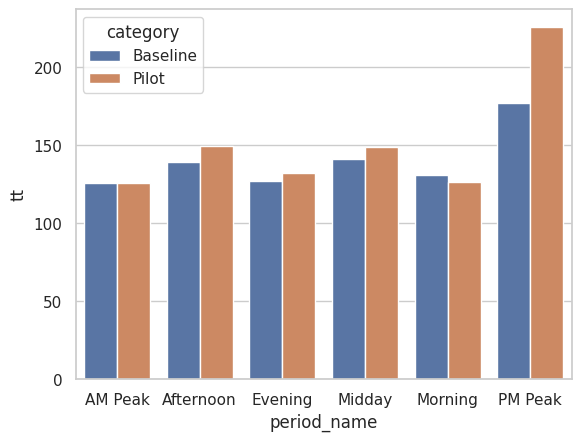

In [43]:
Yonge_J = compare_bar(travel_times, YJ_SegCode, 'period_name', True)
Yonge_J

In [52]:
def compare_diff(table_name,segment_of_interest, column_name, minutes):
  clean_data = table_name[table_name['result_id'] == segment_of_interest]
  clean_data = clean_data.dropna(subset=['period_name'])
  clean_data = clean_data[clean_data['category']!= 'Excluded']

  compare_summary = clean_data.groupby(['category', column_name]).mean()
  compare_summary = compare_summary.reset_index()

  pivoted_data = compare_summary.pivot(index= column_name, columns='category', values='tt')
  if minutes == True:
    pivoted_data = pivoted_data/60

  pivoted_data['the_diff'] = (pivoted_data['Pilot']-pivoted_data['Baseline'])/pivoted_data['Baseline']*100

  ax1=pivoted_data['the_diff'].plot(kind='bar', figsize=(8,6), color='yellow')
  ax1.set_ylabel('Percentage Change [%]')
  ax1.set_xlabel('period_name')

  return ax1


<ipython-input-52-a6dfe5e57612>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  compare_summary = clean_data.groupby(['category', column_name]).mean()


<Axes: xlabel='period_name', ylabel='Percentage Change [%]'>

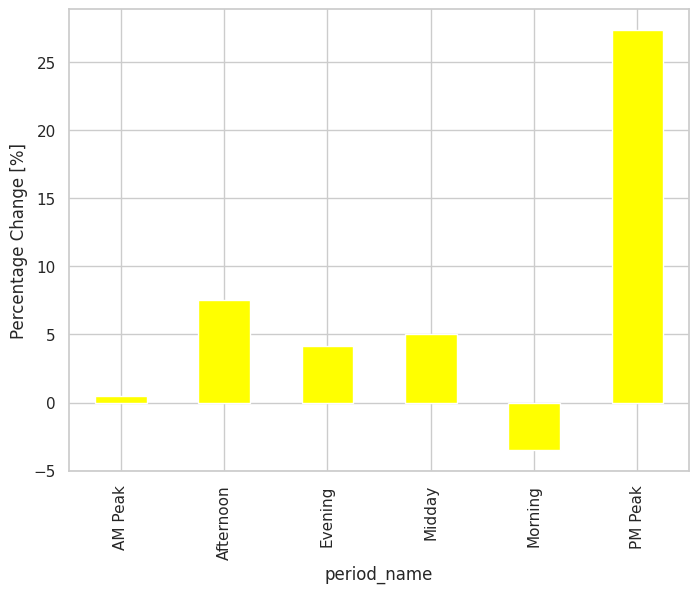

In [53]:
Y_Jarvis = compare_diff(travel_times, YJ_SegCode, 'period_name', True)
Y_Jarvis

## **Extenstion**

please choose the street name you want to analyse. Please capitalize the first letter
King
please enter the begaining street name.
Yonge
please enter the ending street name.
Jarvis
which time slot do you want to see? 
 Please type "period_name" if you want to see all time slots.
Please choose from "AM Peak", "PM Peak", "Afternoon", "Evening", "Midday", "Morning" 
period_name
Do you want your result in Min or Sec? n\ If in min, please enter "True". if in seconds, please enter "False". 
True


<ipython-input-66-7a4a1a9e6640>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  compare_summary = clean_data.groupby(['category', column_name]).mean()


category       Baseline       Pilot   the_diff
period_name                                   
AM Peak      125.447674  126.033225   0.466769
Afternoon    138.918182  149.383750   7.533620
Evening      127.094575  132.392921   4.168822
Midday       141.419978  148.520176   5.020647
Morning      131.000000  126.399267  -3.512010
PM Peak      177.343228  225.815584  27.332510
do you want to see a bar chart of comparison? Please enter "Yes" or "No". 
Yes


<ipython-input-42-c04e4190d4c3>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  compare_summary = clean_data.groupby(['category', column_name]).mean()


do you want to see a bar chart of travel time difference? 
 Please answer "Yes" or "No". 
Yes


<ipython-input-52-a6dfe5e57612>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  compare_summary = clean_data.groupby(['category', column_name]).mean()


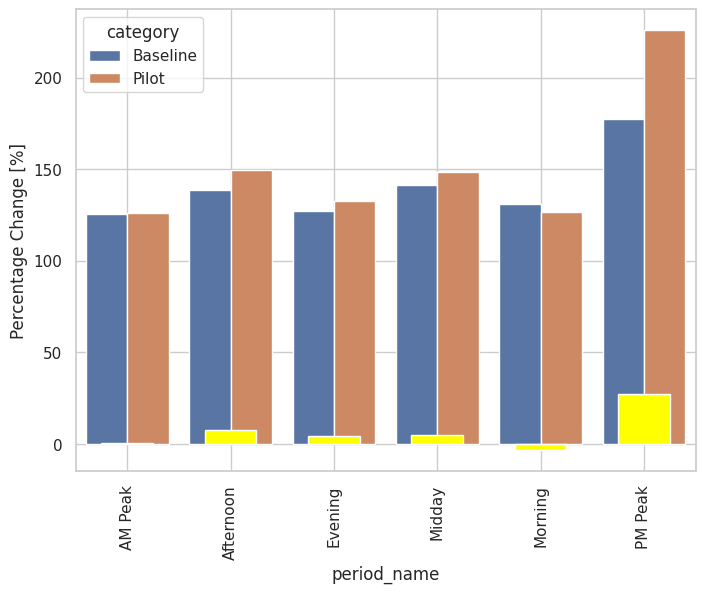

In [79]:
print('please choose the street name you want to analyse. Please capitalize the first letter')
street_name = input()
print('please enter the begaining street name.')
from_street = input()
print('please enter the ending street name.')
to_street = input()
print('which time slot do you want to see? \n Please type "period_name" if you want to see all time slots.')
print('Please choose from \"AM Peak\", \"PM Peak\", \"Afternoon\", \"Evening\", \"Midday\", \"Morning\" ')
column_name = input()
print('Do you want your result in Min or Sec? n\ If in min, please enter \"True". if in seconds, please enter \"False". ')
minutes_bool = input()

#you do not need to change data below this line
#--------------------------------------------------------------

time_unit = 'seconds'
if minutes_bool == True:
    time_unit = 'minutes'

segment_of_interest = get_segment(street_name, from_street, to_street, table2)

pivoted_data = final_analysis(travel_times,segment_of_interest, column_name, minutes_bool)

print(pivoted_data)

#---------------------------------------------------------------
print('do you want to see a bar chart of comparison? Please enter \"Yes" or \"No". ')
answer1 = input()
if answer1 == 'Yes':
  compare_bar(travel_times,segment_of_interest, column_name, minutes_bool)
else:
  None

#----------------------------------------------------------------
print('do you want to see a bar chart of travel time difference? \n Please answer \"Yes" or \"No". ')
answer2 = input()
if answer2 == 'Yes':
  compare_diff(travel_times,segment_of_interest, column_name, minutes_bool)
else:
  None
